In [1]:
import matplotlib.pyplot as plt
import os
import json
import model_helpers as mh
from neuron import h, load_mechanisms
from netpyne import specs, sim
%matplotlib inline

--No graphics will be displayed.


In [1]:
import numpy as np

In [2]:
search = np.zeros((4,2,2))
search

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

In [6]:
np.zeros(2)

array([0., 0.])

## Define model

In [2]:
code_version = 'Hay'
flag = ''  # -Converted for NML->NEURON with pnml

In [3]:
model_version = 'NeuroML'

if 'Hay' in code_version:
    nmldb_id = 'NMLCL000073'  # 'NMLCL000073' (Hay et al. 2011)
    model_name = f'{nmldb_id}-{model_version}{flag[:2]}'

    cell_model = 'Hay2011'  # 'Hay2011'
    cell_type = 'PYR'
    cell_name = 'L5PC'  # 'L5PC'
else:
    nmldb_id = 'NMLCL001535'  # 'NMLCL000073' (Hay et al. 2011)
    model_name = f'{nmldb_id}-{model_version}'

    cell_model = 'Allen'  # 'Hay2011'
    cell_type = 'PYR'
    cell_name = 'Cell_473863035'  # 'L5PC'


## Define paths

In [4]:
hoc_name = cell_name  # 'L5PC'

cwd = os.getcwd()
models_dir = os.path.join(cwd, 'models')
model_dir = os.path.join(models_dir, model_version, model_name)  # 'L5bPCmodelsEH')
hocs_dir = model_dir if 'biophys' not in model_name else os.path.join(model_dir,'models')
mod_dir = model_dir if 'biophys' not in model_name else os.path.join(model_dir, 'mod')


## Download model

In [5]:
mh.download_from_nmldb(nmldb_id, model_version)

Model NMLCL000073 already downloaded.


In [6]:
output_dir = os.path.join(model_dir,'output')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## Compile mechanisms

In [7]:
mh.compile_mechs(cwd,hocs_dir,mod_dir)
load_mechanisms(model_dir)

Mechanisms already compiled!


True

## Import cell into NetPyNE - NEURON

In [8]:
hoc_file = os.path.join(hocs_dir, cell_name+'.hoc')

In [9]:
# Network parameters
netParams = specs.NetParams()

In [10]:
cell_label = cell_name+'_hoc'

netParams.importCellParams(
    label=cell_label,
    conds={'cellType': cell_type, 'cellModel': cell_model},
    fileName=hoc_file,
    cellName=cell_name,
    importSynMechs=False
)

File name should end in '.hoc', '.py', or '.swc'


TypeError: cannot unpack non-iterable NoneType object

In [22]:
netParams.cellParams.keys()

odict_keys(['L5PC_hoc'])

In [23]:
netParams.cellParams[cell_label]['secs'].keys()

dict_keys(['soma_0', 'axon_0', 'apic_0', 'dend_79', 'dend_78', 'dend_63', 'dend_42', 'dend_39', 'dend_16', 'dend_7', 'dend_0', 'axon_1', 'apic_104', 'apic_1', 'dend_81', 'dend_80', 'dend_71', 'dend_64', 'dend_46', 'dend_43', 'dend_41', 'dend_40', 'dend_34', 'dend_17', 'dend_11', 'dend_8', 'dend_6', 'dend_1', 'apic_106', 'apic_105', 'apic_99', 'apic_2', 'dend_83', 'dend_82', 'dend_73', 'dend_72', 'dend_68', 'dend_65', 'dend_52', 'dend_47', 'dend_45', 'dend_44', 'dend_36', 'dend_35', 'dend_25', 'dend_18', 'dend_15', 'dend_12', 'dend_10', 'dend_9', 'dend_3', 'dend_2', 'apic_108', 'apic_107', 'apic_103', 'apic_100', 'apic_80', 'apic_3', 'dend_75', 'dend_74', 'dend_70', 'dend_69', 'dend_67', 'dend_66', 'dend_60', 'dend_53', 'dend_51', 'dend_48', 'dend_38', 'dend_37', 'dend_29', 'dend_26', 'dend_20', 'dend_19', 'dend_14', 'dend_13', 'dend_5', 'dend_4', 'apic_102', 'apic_101', 'apic_88', 'apic_81', 'apic_79', 'apic_4', 'dend_77', 'dend_76', 'dend_62', 'dend_61', 'dend_55', 'dend_54', 'dend_50

## Create Population

In [24]:
pop_label = cell_label+'_pop'
netParams.popParams[pop_label] = {'cellType': cell_type, 'numCells': 1, 'cellModel': cell_model}

## Simulation Configuration

In [8]:
if 'Hay' in code_version:
    input_amps = [-0.5, 0.35477, 0.44346, 0.53215, 1.0643]
else:
    input_amps = [0.10574, 0.13218, 0.15862, 0.31723]

amp_idx = -1  # -1 = no input
input_amp = input_amps[amp_idx]
test_label = f'input_{amp_idx}-tests'
# test_label = f'no_input-new_v_init'

In [12]:
## cfg
cfg = specs.SimConfig()					            # object of class SimConfig to store simulation configuration
cfg.duration = 3000 						            # Duration of the simulation, in ms
cfg.dt = 0.01								                # Internal integration timestep to use
cfg.verbose = 1							                # Show detailed messages
cfg.recordTraces = {'V_soma':{'sec':'soma_0','loc':0.5,'var':'v'}}  # Dict with traces to record
cfg.recordStep = 0.01
cfg.filename = os.path.join(output_dir,cell_name+'_'+test_label) 			# Set file output name
cfg.saveJson = False
cfg.analysis['plotTraces'] = {'include': ['all'], 'saveFig': True} # Plot recorded traces for this list of cells
cfg.hParams['celsius'] = 36 
cfg.hParams['v_init'] = -80

## Add Linear Probe

In [10]:
####################
# Geometry
# --------
# (Cartesian axes)
#          y    z
#          ^  ^
#          | /
#   x <--- o --
#         /|
####################

probe_L = 1280
channels = 1
depths = 10
elec_dist = probe_L//depths  # microns

elec_pos = [[x*elec_dist, y*elec_dist - 150, 0] for x in range(channels) for y in range(depths)]
elec_pos

[[0, -150, 0],
 [0, -22, 0],
 [0, 106, 0],
 [0, 234, 0],
 [0, 362, 0],
 [0, 490, 0],
 [0, 618, 0],
 [0, 746, 0],
 [0, 874, 0],
 [0, 1002, 0]]

In [16]:
# cfg.recordLFP = elec_pos
# cfg.analysis['plotLFP'] = {'saveFig': True}

## Add Input

In [27]:
if amp_idx > -1:
    netParams.stimSourceParams['Input_IC'] = {
        'type': 'IClamp',
        'del': 700,
        'dur': 2000,
        'amp': input_amp  
    }

    netParams.stimTargetParams['Input_IC->Soma'] = {
        'source': 'Input_IC',
        'sec': 'soma_0',
        'loc': 0.5,
        'conds': {'pop': pop_label}
    }

    print(f'current clamp added at {input_amp} pA')
else:
    print('no input')

no input


## Run Simulation

In [28]:
sim.createSimulateAnalyze(netParams = netParams, simConfig = cfg)


Start time:  2024-01-03 12:42:40.762348

Creating network of 1 cell populations on 1 hosts...
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=0) of pop L5PC_hoc_pop, on node 0, 
Instantiated 1 cells of population L5PC_hoc_pop
  Number of cells on node 0: 1 
  Done; cell creation time = 0.12 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
  Recording  V_soma from cell  0  with parameters:  {'sec': 'soma_0', 'loc': 0.5, 'var': 'v'}
Vector[2]
   Recording: spkt:
   Recording: spkid:
   Recording: V_soma:
      cell_0
   Recording: t:
Recording 1 traces of 1 types on node 0

Setting h global variables ...
  h.celsius = 36
  h.v_init = -80
  h.clamp_resist = 0.001
  h.tstop = 3000.0
Minimum delay (time-step for queue exchange) is 10.00

Running simulation using NEURON for 3000.0 ms...
  Done; run time = 100.18 s; real-time ratio: 0.0

## Run in NEURON

In [19]:
from neuron.units import mV, ms
%matplotlib inline

h.load_file('stdrun.hoc')
h.load_file(hoc_file)

1.0

In [20]:
h.cvode_active(0)
h.tstop = 3000 * ms
h.celsius = 34
h.steps_per_ms = 100
h.dt = 1.0 / h.steps_per_ms
h.finitialize(-89.26 * mV)

1.0

In [21]:
hoc_cell = getattr(h, cell_name)
hoc_cell()

L5PC[0]

In [22]:
cell = hoc_cell[0]
soma = cell.soma_0

In [23]:
if 'Hay' in code_version:
    input_amps = [0, 0.35477, 0.44346, 0.53215, 1.0643]
else:
    input_amps = [0, 0.10574, 0.13218, 0.15862, 0.31723]

ts = []
vs = []

for idx, input_amp in enumerate(input_amps):

    ic = h.IClamp(soma(0.5))
    ic.delay = 700*ms
    ic.dur = 2000*ms
    ic.amp = input_amp

    t = h.Vector().record(h._ref_t)
    v = h.Vector().record(soma(0.5)._ref_v)

    h.run()

    ts.append(list(t))
    vs.append(list(v))

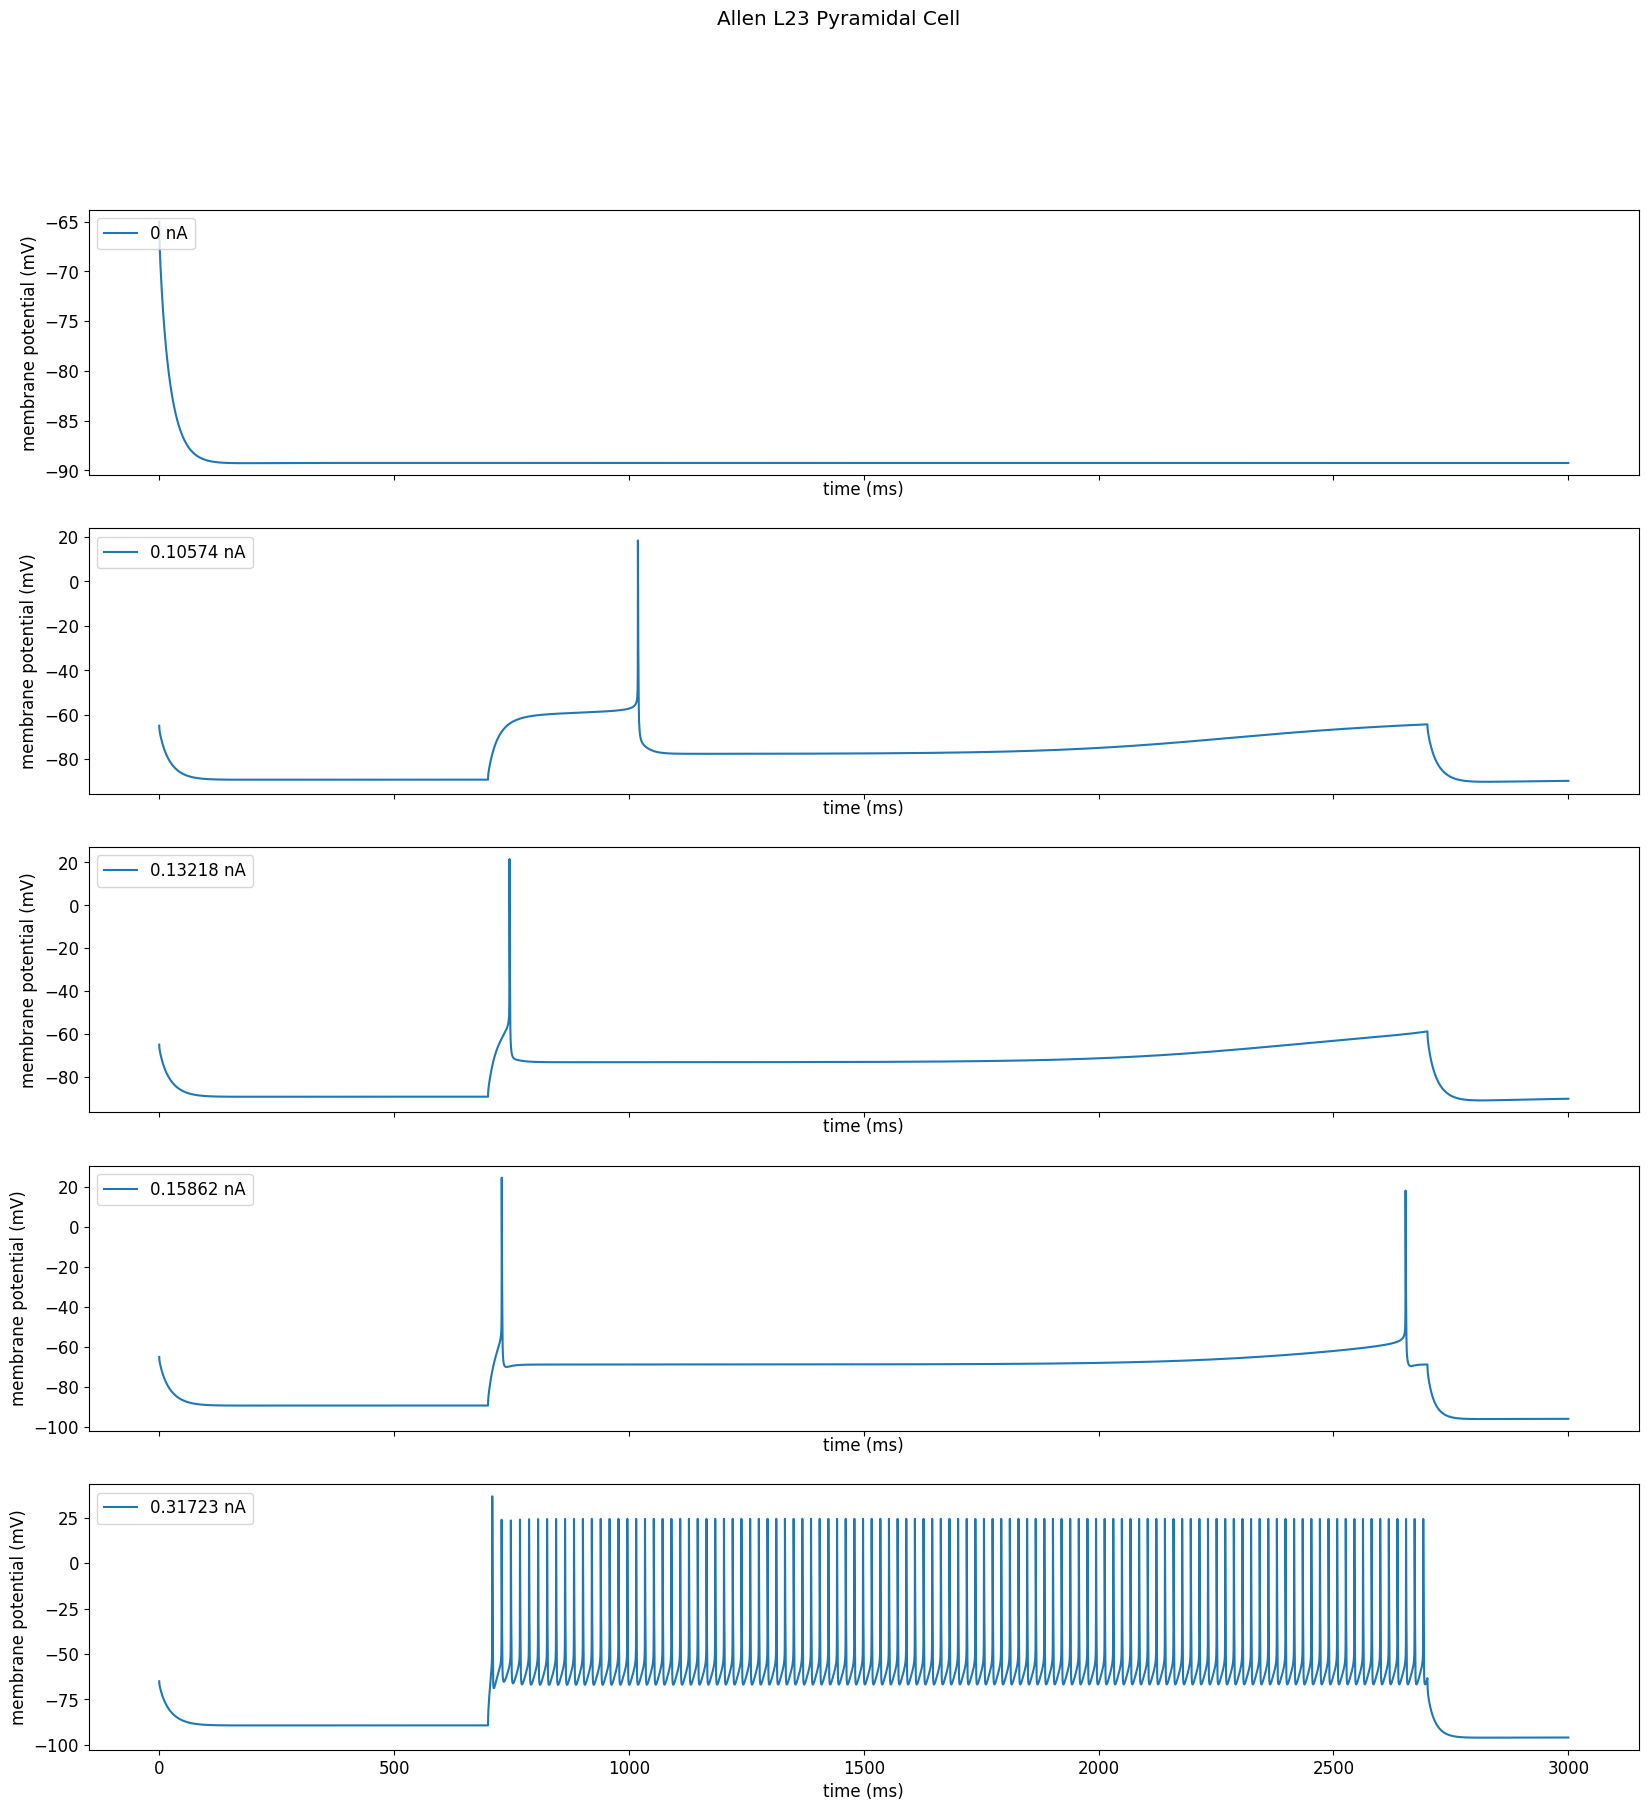

In [ ]:
fig, axs = plt.subplots(len(input_amps), 1, figsize=(20,20), sharex=True)
axs = axs.ravel()

for idx, (t, v) in enumerate(zip(ts, vs)):

    axs[idx].plot(list(t),list(v),label=f'{input_amps[idx]} nA')
    
    axs[idx].legend(loc='upper left')
    axs[idx].set_xlabel('time (ms)')
    axs[idx].set_ylabel('membrane potential (mV)')

if 'Hay' in code_version:
    fig.suptitle('Hay 2011 L5 Pyramidal Cell')
else:
    fig.suptitle('Allen L23 Pyramidal Cell')

fig.savefig(os.path.join(output_dir,cell_name+'_NEURON-sims.jpg'), dpi=300)

In [ ]:
os.path.join(output_dir,cell_name+'_NEURON-sims.jpg')

'/home/kedoxey/CRCNS/PyramidalCellSimulations/models/NEURON/NMLCL000073-NEURON/output/L5PC_NEURON-sims.jpg'

## Plot Morphology

In [20]:
sim.analysis.plotShape(includePre = [], includePost=[pop_label], showSyns=False, figSize=(4,9), dist=0.8, saveFig=True)

Plotting 3D cell shape ...


(<Figure size 400x900 with 1 Axes>, {})